# Bag of Features Multi-Class Classification

This notebook contains the pipeline that allows to perform classification experiments of the Multi-Class version of this problem. **Cardboard**, **Metal**, **Paper**, **Glass**, and **Plastic** are the classes that are considered in this set of experiments. The used <u>data set</u> may be found in the following [Kaggle Repository](https://www.kaggle.com/asdasdasasdas/garbage-classification). 

clean_research_practice1_version.ipynb set the baseline in order to work with in this notebook, the binary classification version of the problem is worked in there. In case of doubts, this should be the reference to be consulted.

# Imports




In [1]:
%%capture
# Import helper functions
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/file_management.py
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/evaluation_functions.py
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/image_processing.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
import os
import errno

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

from file_management import bring_data, walk_through_dir, copy_folder
from image_processing import (center_image_IDG, get_visual_dictionary, 
                              get_histogram, applypca, applynmf)
from evaluation_functions import (hyperparametertunning, learningcurve, 
                                  plotlearningcurve, multiclass_CV, 
                                  print_wrong_predictions)
from helper_functions import make_confusion_matrix

import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Mounted at /content/drive/


 # Preprocessing

## Load the Data

In [3]:
path_list = ['/content/drive/MyDrive/PI2/data/cardboard.zip',
            '/content/drive/MyDrive/PI2/data/metal.zip',
             '/content/drive/MyDrive/PI2/data/glass.zip',
             '/content/drive/MyDrive/PI2/data/paper.zip',
             '/content/drive/MyDrive/PI2/data/plastic.zip']

# Unzip the data
bring_data(path_list=path_list)

# How many images/classes are there?
walk_through_dir("data")

Not found
There are 5 directories and 0 images in 'data'.
There are 0 directories and 403 images in 'data/cardboard'.
There are 0 directories and 482 images in 'data/plastic'.
There are 0 directories and 410 images in 'data/metal'.
There are 0 directories and 501 images in 'data/glass'.
There are 0 directories and 594 images in 'data/paper'.


## Run Processing Funtions

In [19]:
# Image paths
image_dir = '/content/data/'

IMG_SIZE = (75, 75)
COLOR_MODE = "grayscale"
CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
BATCH_SIZE = 32
CLASS_MODE = 'sparse'
SHUFFLE = False
N = 403

params = dict(target_size=IMG_SIZE, color_mode=COLOR_MODE, 
              class_mode=CLASS_MODE, shuffle=SHUFFLE)

# BoF
patch_size, step_size = 10,3

# Create Image Data Generator
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=center_image_IDG)

# Processing techniques included
data_gen = image_generator.flow_from_directory(directory='data', 
                                               batch_size = 2390,
                                               classes=CLASSES,
                                               **params)

# Extracting train and test images and labels
images, labels = data_gen.next()

# Convert labels into dataframe to extract random samples
labels_df = pd.DataFrame(labels)

# Extract random samples of the data with their indices and concatenate them
cardboard = labels_df[labels_df[0] == 0].sample(N).index.tolist()
glass = labels_df[labels_df[0] == 1].sample(N).index.tolist()
metal = labels_df[labels_df[0] == 2].sample(N).index.tolist() 
paper = labels_df[labels_df[0] == 3].sample(N).index.tolist()
plastic = labels_df[labels_df[0] == 4].sample(N).index.tolist()
indexes = cardboard + glass + metal + paper + plastic
indexes = np.sort(indexes)

# Choose balanced images
balanced_images = images[indexes]
balanced_images = balanced_images.reshape(balanced_images.shape[:-1])
balanced_labels = labels[indexes]
image_filenames = np.array(data_gen.filenames)[indexes]

Found 2390 images belonging to 5 classes.


## Bag of Features

In [20]:
# Bag of Features
vdict = get_visual_dictionary(balanced_images, patch_size, step_size, 60)
Xh = [get_histogram(img, patch_size, step_size, vdict) \
      for img in balanced_images]
Xh = np.array(Xh)

Xh = pd.DataFrame(Xh)
Xh.fillna(0, inplace = True)

# Assign y
y = balanced_labels

## Print n images

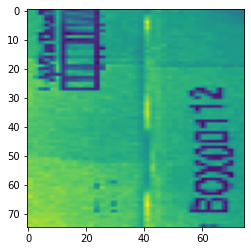

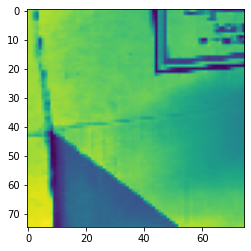

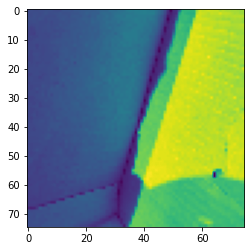

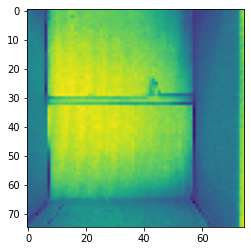

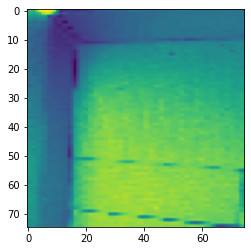

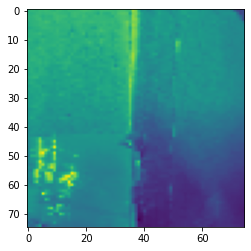

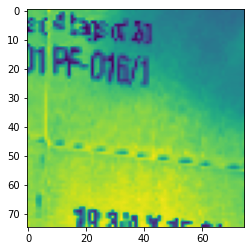

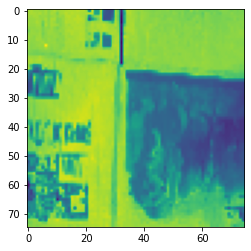

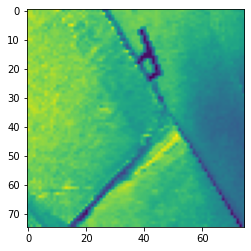

In [21]:
n = 10

for img in balanced_images[1:n]:
    plt.imshow(img[:,:])
    plt.show()

## Dimension Reduction

In [22]:
# Apply PCA
Xh_pca, pca = applypca(Xh) 

variance = pca.explained_variance_ratio_

suma = 0
cont = 0
while suma < 0.8:
  suma += variance[cont]
  cont += 1

Xh_pca80 = Xh_pca.iloc[:,:cont]

# Apply NMF
Xh_nmf, nmf = applynmf(Xh, cont)

print("Original BoF shape:",Xh.shape)
print("BoF PCA shape:",Xh_pca.shape)
print("BoF PCA80 shape",Xh_pca80.shape)
print("BoF NMF shape",Xh_nmf.shape)

Original BoF shape: (2015, 60)
BoF PCA shape: (2015, 60)
BoF PCA80 shape (2015, 9)
BoF NMF shape (2015, 9)


# Testing

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Create the model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Data assignation
X = Xh.to_numpy(dtype=np.float32)
y = balanced_labels

# Stratified Splitting 
k = 10
skf = StratifiedKFold(n_splits=k)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):

    # Split data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Print Value Counts
    # print('\nSplit Number ', i,'\n')
    # print('Train class value count: \n',pd.Series(y_train).value_counts())
    # print('Test class value count: \n',pd.Series(y_test).value_counts())
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)



0.46534653465346537
0.5
0.5
0.4752475247524752
0.5396039603960396
0.3781094527363184
0.4925373134328358
0.5223880597014925
0.43781094527363185
0.47761194029850745


# Model Evaluation
## Experiment Setting

In [23]:
# Create Directory
root = 'experiments/'
destination = '/content/drive/MyDrive/PI2/experiments'

try:
    os.mkdir(root)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

# Create Experiment Directory
experiment = str(input('Type Experiment Name: '))
path = root + experiment
try:
    os.mkdir(path)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise
model_name = str(input('Type Model Name: '))

# Create training dictionary
X_dict = {'BoF':Xh,'BoF-PCA':Xh_pca,'BoF-PCA80':Xh_pca80,'BoF-NMF':Xh_nmf}

Type Experiment Name: WRONG_TEST
Type Model Name: LR


## Hyperparameter Tunning

In [24]:
%%capture

# Classifier
model = LogisticRegression(multi_class='multinomial')

# Create parameter grid
penalty = ['l1','l2','elasticnet','none']
C = np.logspace(0,4,10)
hyperparameters = dict(C=C, penalty=penalty)#, multiclass=multi_class)

# Tune Hyperparameters
param_dict, param_title_dictionary = hyperparametertunning(model, X_dict, y, 
                                                           hyperparameters, 5, 
                                                           'f1_macro')

## Learning Curves

In [25]:
%%capture
(train_sizes_dict, train_scores_mean_dict, train_scores_std_dict,
  test_scores_mean_dict, 
  test_scores_std_dict) = learningcurve(model, X_dict, y, 
                                        5, param_dict, 'f1_macro', 
                                        np.linspace(0.1,1,50))

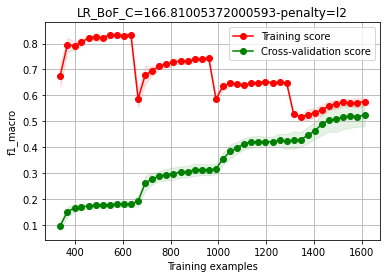

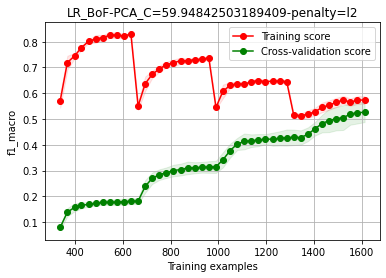

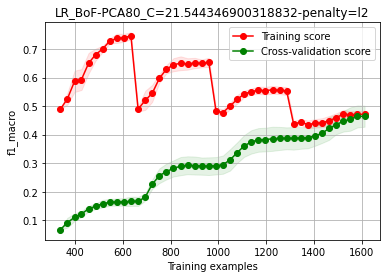

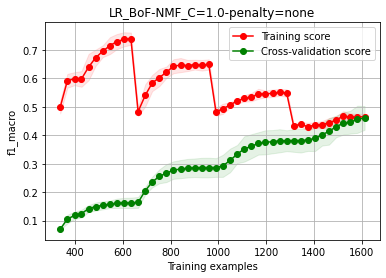

In [26]:
plotlearningcurve(model_name, param_dict, param_title_dictionary, 'f1_macro', 
                  train_sizes_dict, train_scores_mean_dict, 
                  train_scores_std_dict, test_scores_mean_dict,
                  test_scores_std_dict, path)

## Evaluating Performance Across Classes

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


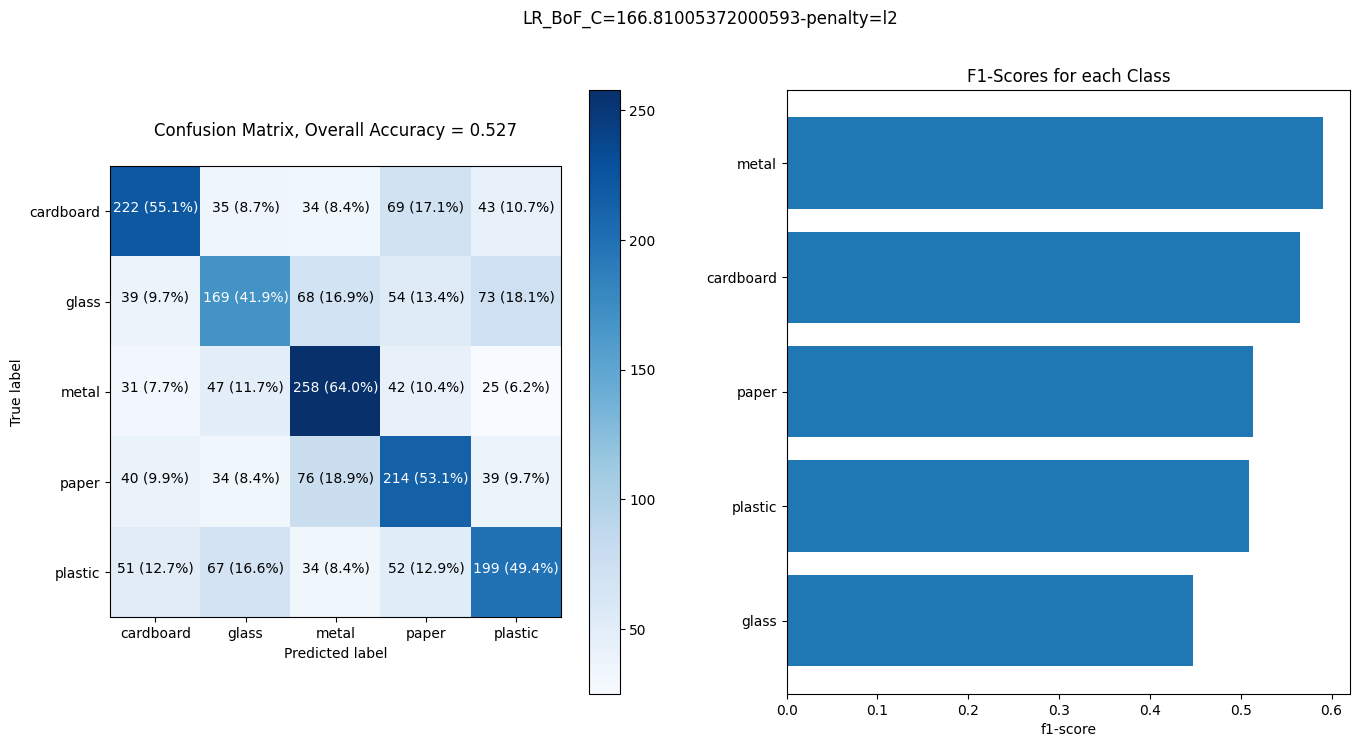

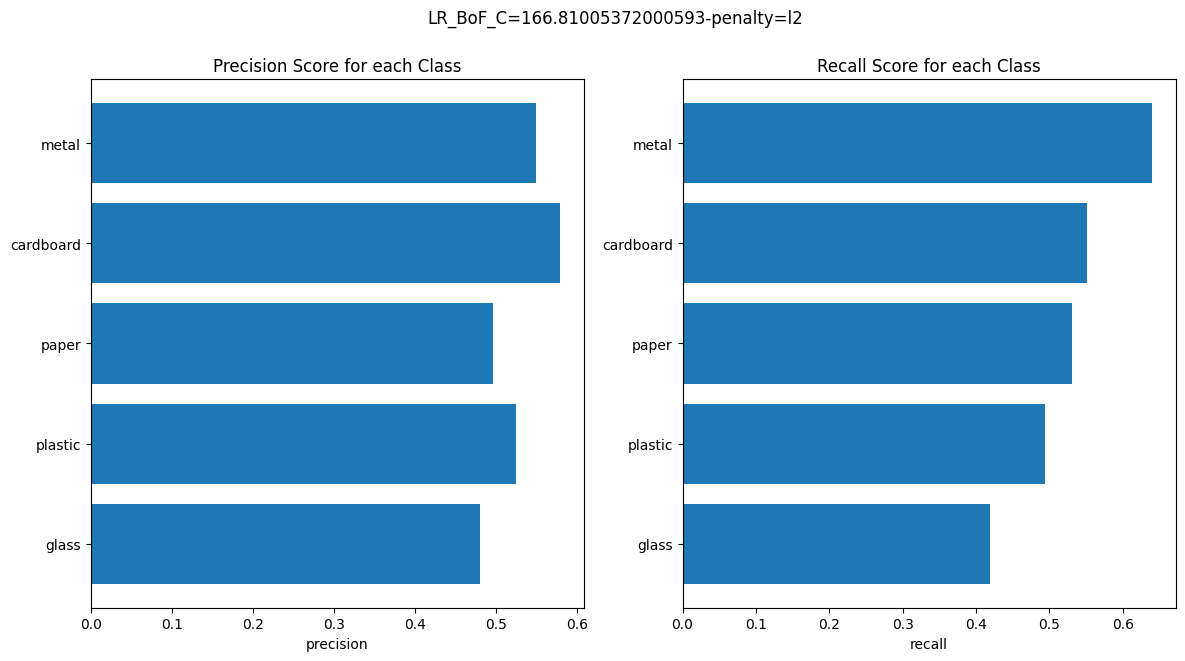

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


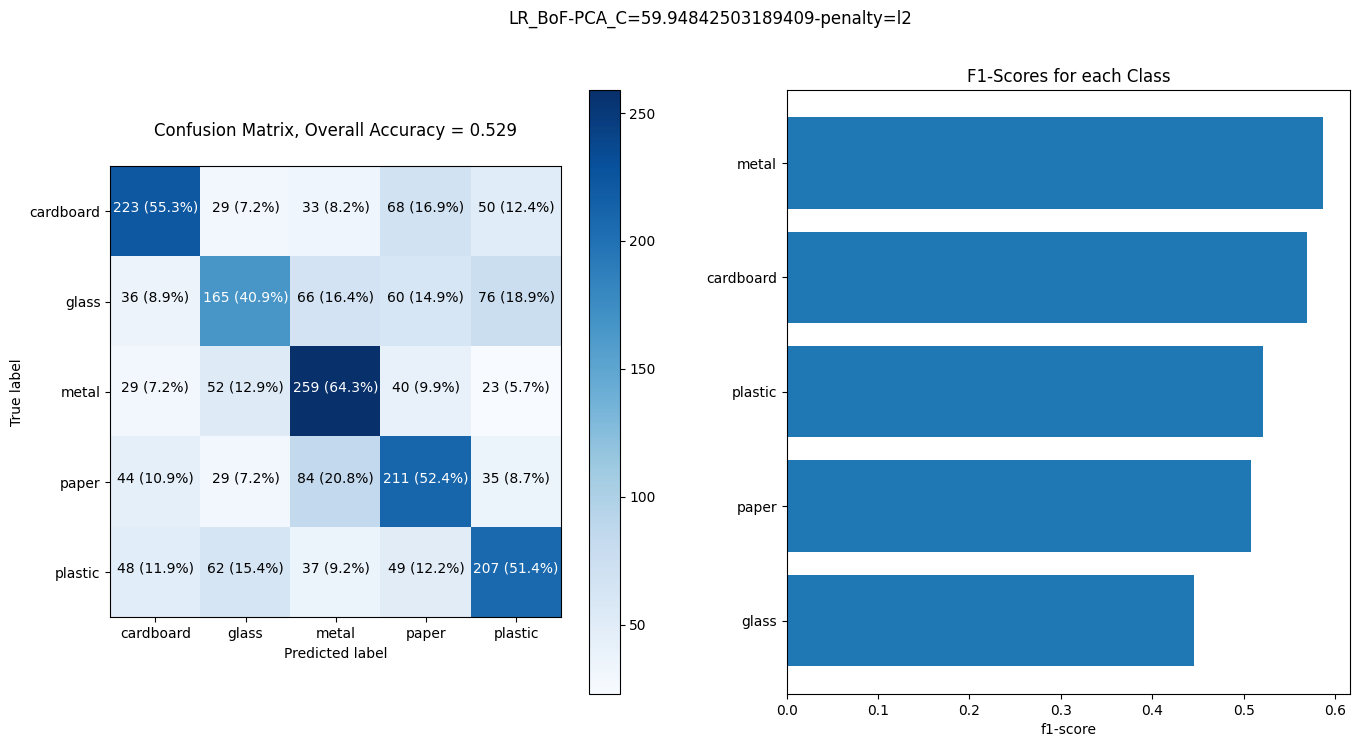

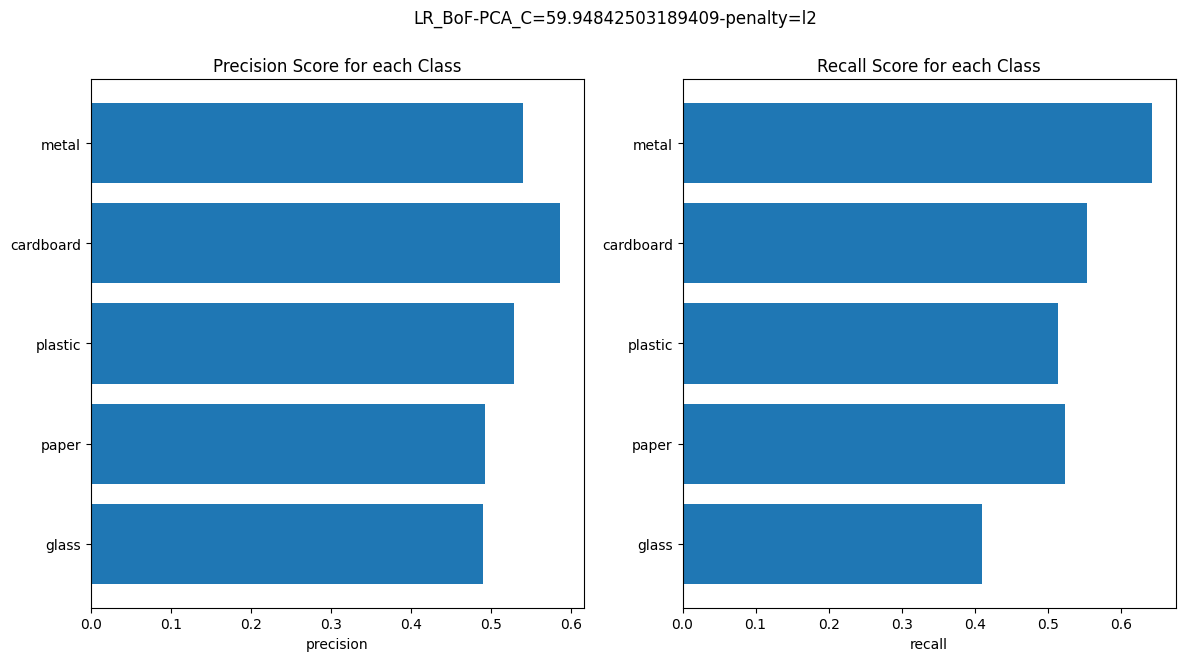

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


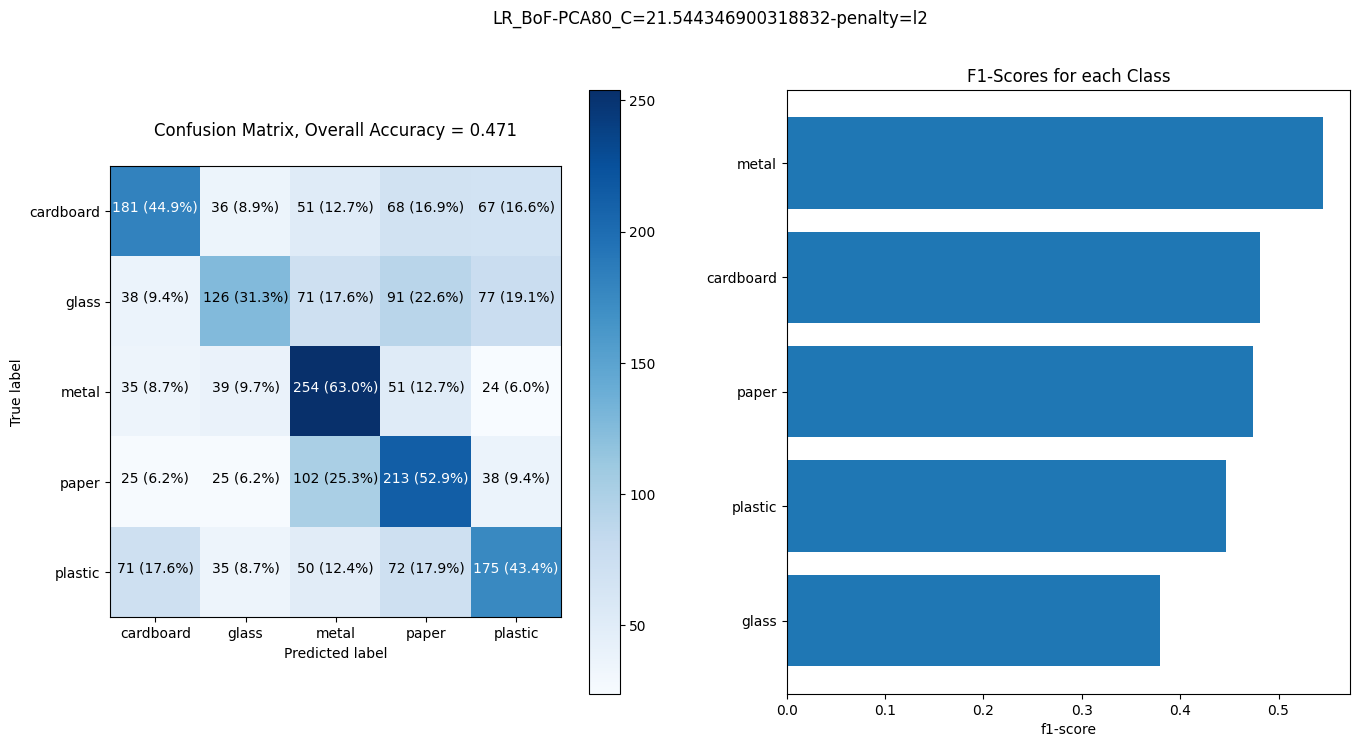

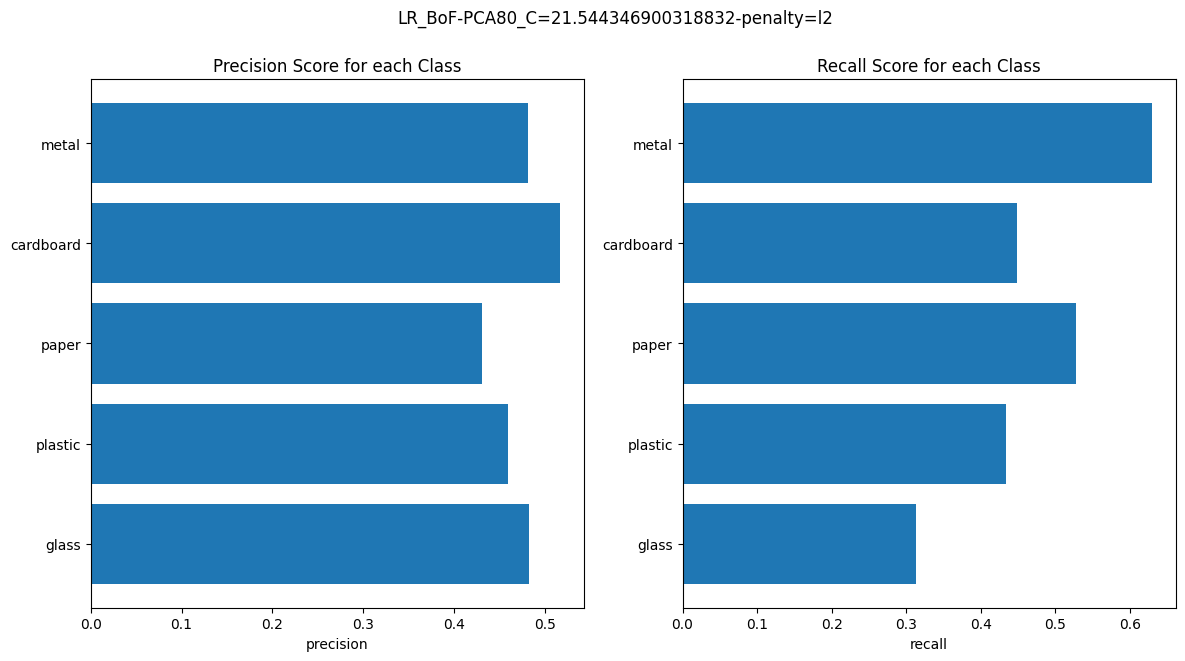

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


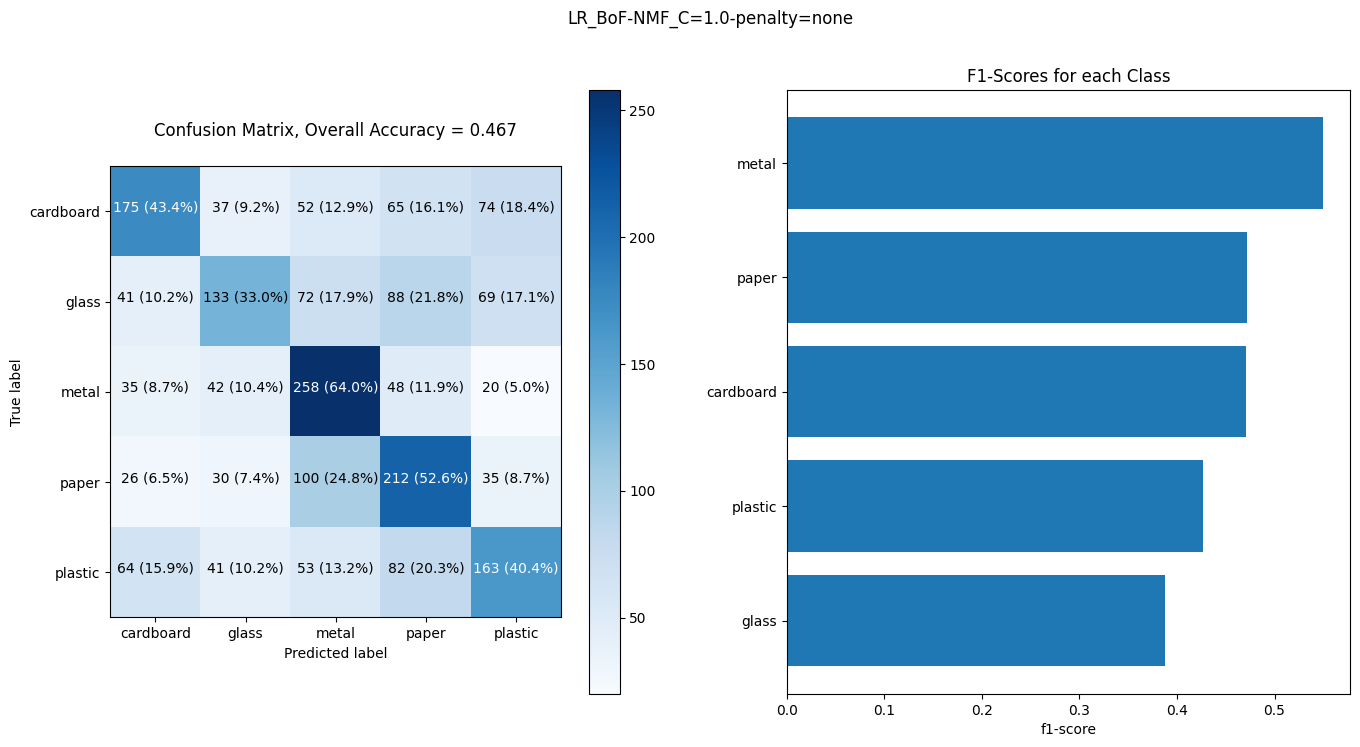

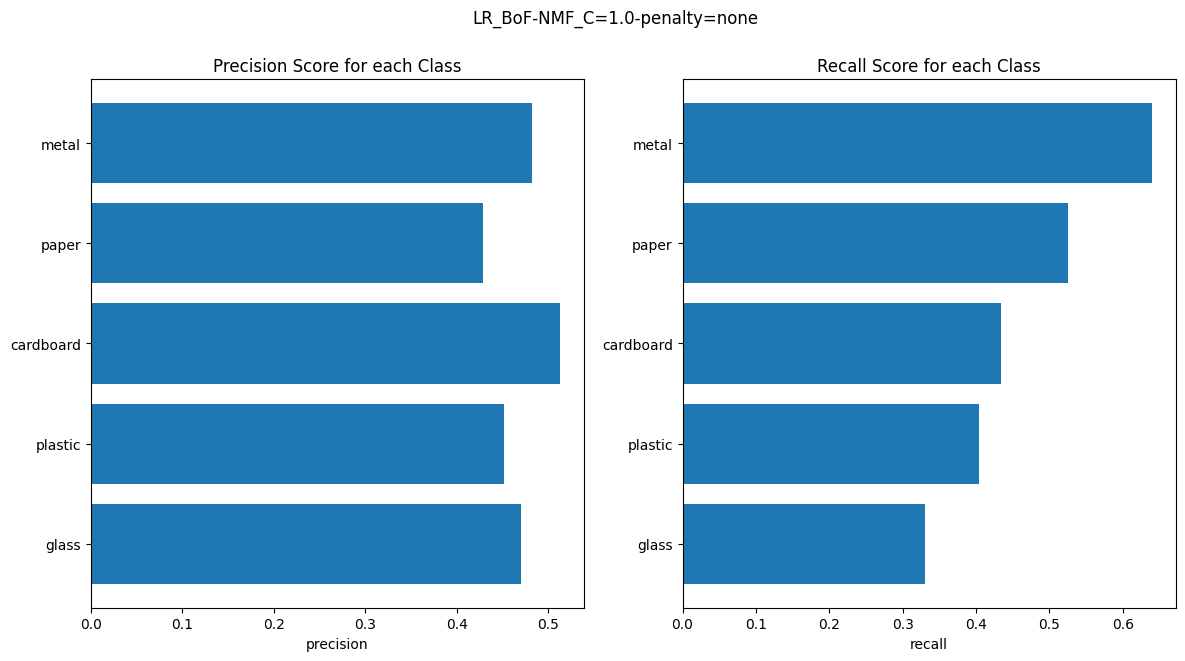

In [27]:
df, model_wrong_preds = multiclass_CV(model, 5, X_dict, y, param_dict, 
                                      param_title_dictionary, CLASSES, 
                                      model_name, path, image_filenames)

In [28]:
df

,model_name,accuracy,cardboard_f1_score,cardboard_precision,cardboard_recall,glass_f1_score,glass_precision,glass_recall,metal_f1_score,metal_precision,metal_recall,paper_f1_score,paper_precision,paper_recall,plastic_f1_score,plastic_precision,plastic_recall
0,LR_BoF_C=166.81005372000593-penalty=l2,0.527047,0.564885,0.579634,0.550868,0.447682,0.480114,0.419355,0.591065,0.548936,0.640199,0.513189,0.49652,0.531017,0.508951,0.525066,0.493797
1,LR_BoF-PCA_C=59.94842503189409-penalty=l2,0.528536,0.569604,0.586842,0.55335,0.445946,0.489614,0.409429,0.587302,0.54071,0.64268,0.507822,0.492991,0.523573,0.521411,0.529412,0.513648
2,LR_BoF-PCA80_C=21.544346900318832-penalty=l2,0.470968,0.480744,0.517143,0.449132,0.379518,0.482759,0.312655,0.54565,0.481061,0.630273,0.474388,0.430303,0.528536,0.446429,0.459318,0.434243
3,LR_BoF-NMF_C=1.0-penalty=none,0.466998,0.47043,0.513196,0.434243,0.387755,0.469965,0.330025,0.550107,0.482243,0.640199,0.47216,0.428283,0.526055,0.426702,0.451524,0.404467


In [29]:
model_wrong_preds['BoF']

,img_path,y_true,y_pred,pred_prob,y_true_classname,y_pred_classname,pred_correct
297,/data/paper/paper172.jpg,3.0,0,0.976538,paper,cardboard,False
294,/data/paper/paper166.jpg,3.0,2,0.953826,paper,metal,False
70,/data/cardboard/cardboard162.jpg,0.0,3,0.925482,cardboard,paper,False
243,/data/paper/paper10.jpg,3.0,2,0.918336,paper,metal,False
803,/data/plastic/plastic264.jpg,4.0,0,0.914701,plastic,cardboard,False
...,...,...,...,...,...,...,...
693,/data/paper/paper267.jpg,3.0,0,0.250513,paper,cardboard,False
848,/data/cardboard/cardboard283.jpg,0.0,2,0.249510,cardboard,metal,False
1666,/data/cardboard/cardboard76.jpg,0.0,4,0.249095,cardboard,plastic,False
1541,/data/plastic/plastic37.jpg,4.0,1,0.244747,plastic,glass,False


## Print Most Wrong Predictions

['/data/paper/paper172.jpg', '/data/paper/paper166.jpg', '/data/cardboard/cardboard162.jpg', '/data/paper/paper10.jpg', '/data/plastic/plastic264.jpg', '/data/plastic/plastic453.jpg', '/data/cardboard/cardboard29.jpg', '/data/glass/glass274.jpg', '/data/metal/metal167.jpg', '/data/cardboard/cardboard205.jpg']
Directory already exist
Found 10 images belonging to 1 classes.


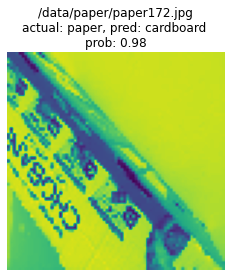

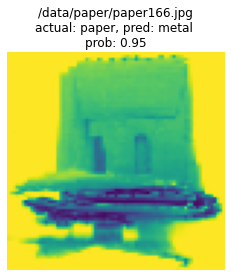

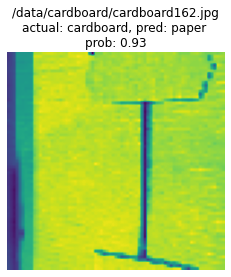

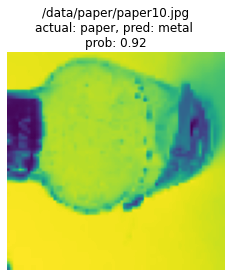

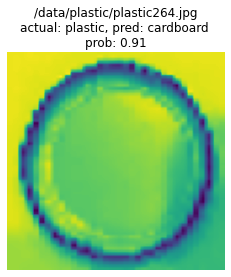

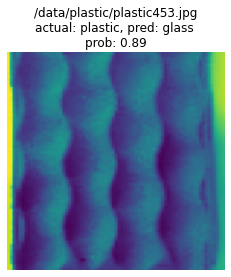

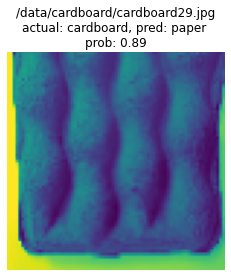

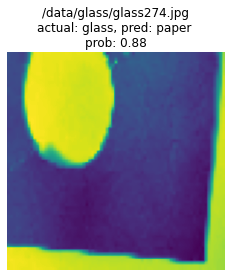

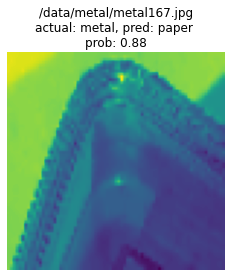

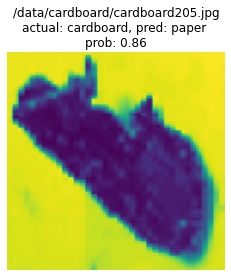

In [35]:
print_wrong_predictions(model_wrong_preds['BoF'], 10, image_generator, params)

## Storing Results

In [17]:
copy_folder(path, destination)

Enter the experiment description:
